In [1]:
%matplotlib inline

## Import libraries

In [2]:
import pandas as pd
import os
import glob
import smopy
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy import ndimage
from datetime import datetime
import imageio

## Load the data

Get the data at https://www.dropbox.com/s/rbuslubhqh33h7v/all.rar?dl=0

In [3]:
%time df = pd.read_csv('all.csv', index_col=0, parse_dates=['datetime'])

<string>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 5min 28s


In [4]:
df.head()

,lat,long,altitude,trajectory_id,subfolder,labels,datetime,distance,timedelta,velocity,acceleration
index,,,,,,,,,,,
0,39.984702,116.318417,492.0,20081023025304,0,NaN,2008-10-23 02:53:04,3.520694,0 days 00:00:06.000000000,0.586782,-0.003189
1,39.984683,116.318450,492.0,20081023025304,0,NaN,2008-10-23 02:53:10,2.838241,0 days 00:00:05.000000000,0.567648,-0.003841
2,39.984686,116.318417,492.0,20081023025304,0,NaN,2008-10-23 02:53:15,2.742220,0 days 00:00:05.000000000,0.548444,0.332144
3,39.984688,116.318385,492.0,20081023025304,0,NaN,2008-10-23 02:53:20,11.045822,0 days 00:00:05.000000000,2.209164,0.391130
4,39.984655,116.318263,492.0,20081023025304,0,NaN,2008-10-23 02:53:25,20.824082,0 days 00:00:05.000000000,4.164816,0.072513


In [5]:
df.describe()

,lat,long,altitude,trajectory_id,subfolder,distance,velocity,acceleration
count,2.487698e+07,2.487698e+07,2.487698e+07,2.487698e+07,2.487698e+07,2.485831e+07,2.415941e+07,2.392863e+07
mean,3.897989e+01,1.123597e+02,5.130172e+02,2.009082e+13,7.660328e+01,5.201501e+01,1.904071e+01,-1.372122e+00
std,4.070501e+00,2.717960e+01,2.301976e+03,1.054322e+10,5.672404e+01,5.833322e+03,2.293823e+03,1.275851e+03
min,1.044024e+00,-1.799696e+02,-3.264760e+04,2.000010e+13,0.000000e+00,0.000000e+00,0.000000e+00,-8.618472e+05
25%,3.990636e+01,1.163065e+02,7.870000e+01,2.008111e+13,2.500000e+01,2.369423e+00,1.017366e+00,-1.833007e-01
50%,3.997498e+01,1.163342e+02,1.476000e+02,2.009032e+13,6.600000e+01,8.723721e+00,3.802349e+00,0.000000e+00
75%,3.999848e+01,1.164194e+02,2.190000e+02,2.009080e+13,1.350000e+02,1.762962e+01,1.247825e+01,1.777199e-01
max,4.001667e+02,1.799969e+02,1.075033e+05,2.012073e+13,1.810000e+02,7.965545e+06,8.618735e+05,4.260505e+05


## Plot the coordinates

In [6]:
smopy.TILE_SERVER = "http://tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png"
smopy.TILE_SIZE = 256

In [7]:
latMin = min(df.lat)
latMax = max(df.lat)
longMin = min(df.long)
longMax = max(df.long)

Lowered zoom level to keep map size reasonable. (z = 2)


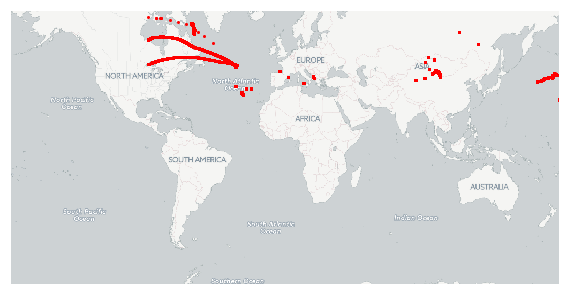

In [8]:
mapAll = smopy.Map((latMin, longMin, latMax, longMax ), z=10)
x, y = mapAll.to_pixels(df.lat, df.long)
ax = mapAll.show_mpl(figsize=(8, 6))
ax.plot(x, y, 'or', ms=2)

## Beijing

In [9]:
latMinB = 39.64
latMaxB = 40.51
longMinB = 115.76
longMaxB = 116.88

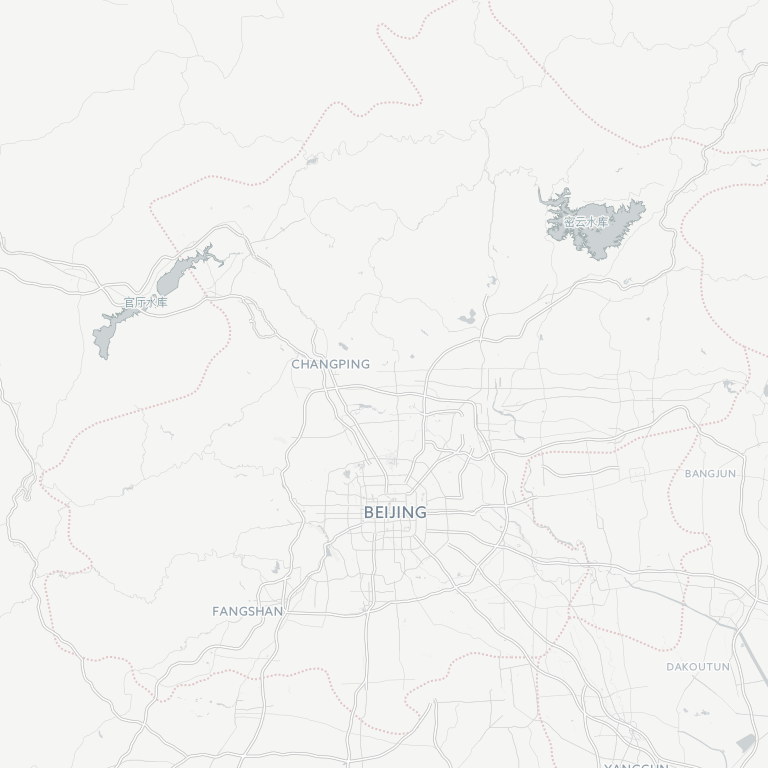

In [10]:
mapBeijing = smopy.Map((latMinB, longMinB, latMaxB, longMaxB ), z=9)
mapBeijing.show_ipython()

## Let's build a heatmap to check out the busy areas

In [11]:
df['xPixel'] = mapBeijing.to_pixels(df.lat, df.long)[0]
df['yPixel'] = mapBeijing.to_pixels(df.lat, df.long)[1]

In [12]:
dfBeijing = df[(df.lat.between(latMinB, latMaxB)) & (df.long.between(longMinB, longMaxB))]

In [13]:
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, (1,0,0,0)), (0.5, (1,0.5,0,0.8)), (0.75, (1,1,0,0.8)), (0.875, (1,1,1,1)), (1, (1,1,1,1))])

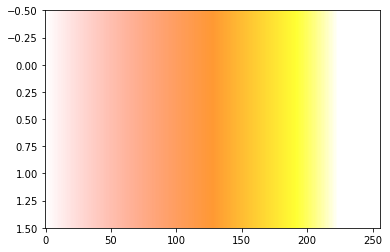

In [14]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots()
ax.imshow(gradient, aspect='auto', cmap=cmap)

E:\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:12: RuntimeWarning: divide by zero encountered in log


11.056707312449186

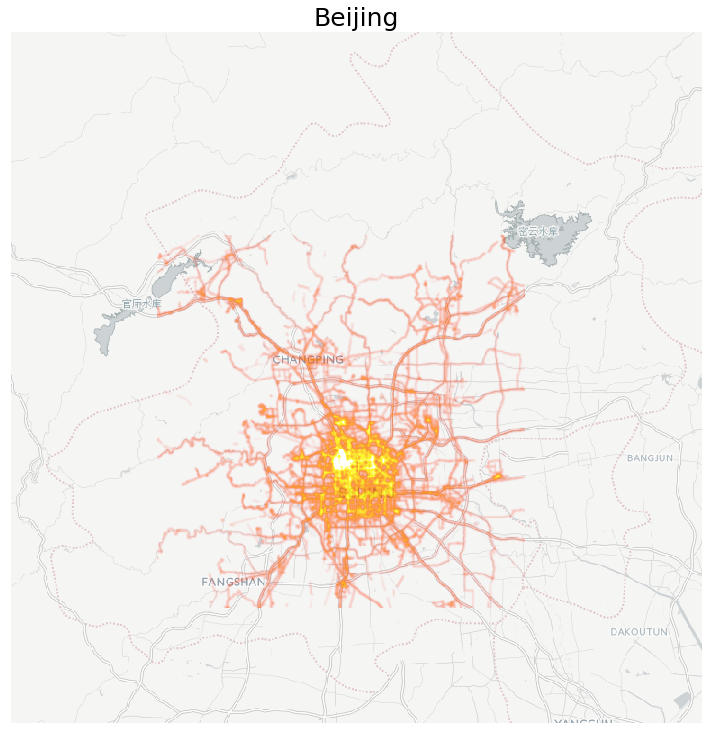

In [15]:
ax = mapBeijing.show_mpl(figsize=(12, 10))
bins=400
smoothing =1.

title = 'Beijing'

x = list(dfBeijing['xPixel'])
y = list(dfBeijing['yPixel'])
heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    
logheatmap = np.log(heatmap)
logheatmap[np.isneginf(logheatmap)] = 0
logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')

ax.set_title(title, size=25)

plt.savefig(title+'.png', bbox_inches='tight')
    
ax.imshow(logheatmap, cmap=cmap, extent=extent, vmin=0, vmax=10)

plt.savefig(title+'.png', bbox_inches='tight')

np.amax(logheatmap)

## Now that we figured out how to make a heatmap, let's put it into a function and zoom into the central area

In [16]:
def heatMap(long, lat, area, bins=200, smoothing=1, vmax=4, title=None):
    x = area.to_pixels(lat, long)[0]
    y = area.to_pixels(lat, long)[1]
    
    ax = area.show_mpl(figsize=(12, 10))
    
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    
    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    output = ax.imshow(logheatmap, cmap=cmap, extent=extent, vmin=0, vmax=vmax)
    
    if title:
        ax.set_title(title, size=25)
        plt.savefig(title+'.png', bbox_inches='tight')
    
    print(np.amax(logheatmap))
    return output

In [17]:
latMin = 39.8
latMax = 40
longMin = 116.2
longMax = 116.4

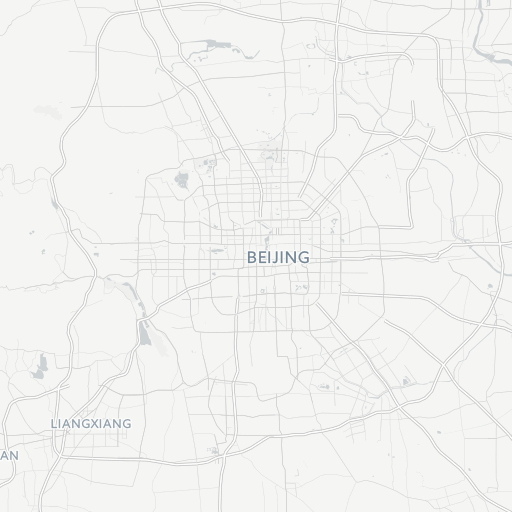

In [18]:
mapZoom = smopy.Map((latMin, longMin, latMax, longMax ), z=10)
mapZoom.show_ipython()

E:\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:10: RuntimeWarning: divide by zero encountered in log


10.492092294


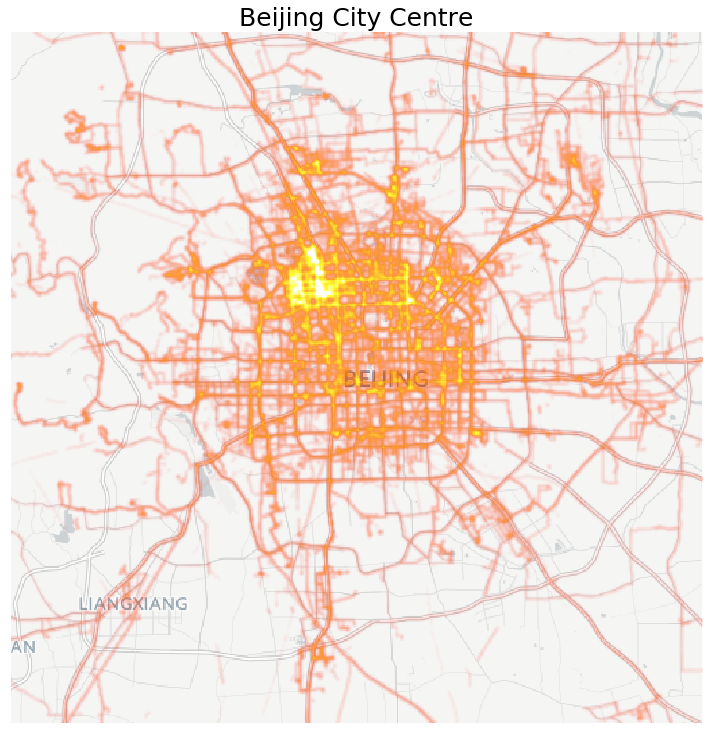

In [19]:
heatMap(dfBeijing.long, dfBeijing.lat, mapZoom, bins=800, vmax=10, title='Beijing City Centre')

## How many trajectories are there?

In [20]:
len(df.trajectory_id.unique())

17784

In [21]:
df.set_index('datetime', inplace=True)

Wall time: 49.1 s


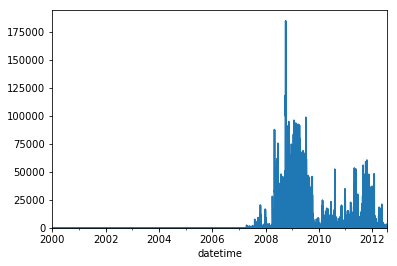

In [22]:
%time df.resample('D').count().lat.plot(kind='area')

## Check out the count of the labels

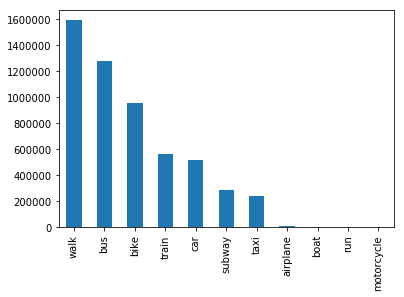

In [ ]:
df['labels'].value_counts().plot(kind='bar')

## Find the busiest roads

In [ ]:
dfRoads = dfBeijing[dfBeijing['labels'].isin(['car', 'bus', 'taxi'])]

In [ ]:
heatMap(dfRoads.long, dfRoads.lat, mapZoom, bins=800, vmax=7, title='roads')

## Where are the walking areas?

## Can we spot the bus lines?

## Is there a difference during the day? 

In [ ]:
def getTime(x):
    return datetime.strptime(str(x), '%H').strftime('%Hh%M')

Build a loop to generate a heatmap for every hour

In [32]:
files = glob.glob('*h00.png')
images = []
for file in files:
    images.append(imageio.imread(file))
imageio.mimsave('24hBeijing.gif', images)

<img src="24hBeijing.gif">